<a href="https://colab.research.google.com/github/sayakpaul/Revisiting-Pooling-in-CNNs/blob/main/SoftPool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements the SoftPool layer as proposed in the [Refining activation downsampling with SoftPool](https://arxiv.org/pdf/2101.00440.pdf) paper. We will also see how to use its 2D variant inside a shallow CNN and train the network. We will be using the CIFAR10 dataset for this purpose.  

## Initial Setup

In [1]:
!nvidia-smi

Tue Jan 26 09:29:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.random.set_seed(666)
print(tf.__version__)

2.4.0


In [3]:
import matplotlib.pyplot as plt
import time

## CIFAR10 dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Preprocessing Utilities

In [5]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

@tf.function
def preprocess_image(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Layer and Model Definitions

In [6]:
# Reference:
# https://github.com/qwopqwop200/SoftPool/blob/main/tensorflow_softpool.py#L14-#L22
class SoftPooling2D(tf.keras.layers.Layer):
    """Implements SoftPool as proposed in https://arxiv.org/pdf/2101.00440.pdf."""
    def __init__(self,pool_size=(2, 2),strides=None,padding='valid',data_format=None):
        super(SoftPooling2D, self).__init__()
        self.avgpool = tf.keras.layers.AvgPool2D(pool_size,strides,padding,data_format)
    def call(self, x):
        x_exp = tf.math.exp(x)
        x_exp_pool = self.avgpool(x_exp)
        x = self.avgpool(x_exp*x)
        return x/x_exp_pool

**Note**: All the hyperparameters like `strides`, `pool_size`, `padding` have been set to their default specifications. 

In [7]:
# Reference:
# https://github.com/ayulockin/LossLandscape/blob/master/MediumCNN_Cifar10.ipynb
def conv_block(x, nb_channels, padding='same', dropout=0.1, 
               pool_type=tf.keras.layers.MaxPool2D):
    x = tf.keras.layers.Conv2D(nb_channels, (3,3), padding=padding, 
                               activation='relu', 
                               kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return pool_type()(x)

def get_training_model(pool_type=tf.keras.layers.MaxPool2D):
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    x = conv_block(inputs, 32)
    x = conv_block(x, 64, padding='valid')
    x = conv_block(x, 128)
    x = conv_block(x, 256)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

## Model Training Utilities

In [8]:
def plot_training(H):
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [9]:
# Early stopping callback to prevent from overfitting
es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

## Model Training

Epoch 1/40
391/391 [==============================] - 4s 10ms/step - loss: 2.1908 - accuracy: 0.1787 - val_loss: 1.5764 - val_accuracy: 0.4589
Epoch 2/40
391/391 [==============================] - 4s 9ms/step - loss: 1.5183 - accuracy: 0.4437 - val_loss: 1.2875 - val_accuracy: 0.5713
Epoch 3/40
391/391 [==============================] - 4s 9ms/step - loss: 1.2660 - accuracy: 0.5452 - val_loss: 1.1569 - val_accuracy: 0.6094
Epoch 4/40
391/391 [==============================] - 4s 10ms/step - loss: 1.1180 - accuracy: 0.6014 - val_loss: 0.9977 - val_accuracy: 0.6687
Epoch 5/40
391/391 [==============================] - 4s 9ms/step - loss: 0.9900 - accuracy: 0.6504 - val_loss: 0.8963 - val_accuracy: 0.7045
Epoch 6/40
391/391 [==============================] - 4s 9ms/step - loss: 0.8722 - accuracy: 0.6974 - val_loss: 0.8435 - val_accuracy: 0.7184
Epoch 7/40
391/391 [==============================] - 4s 9ms/step - loss: 0.7937 - accuracy: 0.7246 - val_loss: 0.8090 - val_accuracy: 0.7318
Epoc

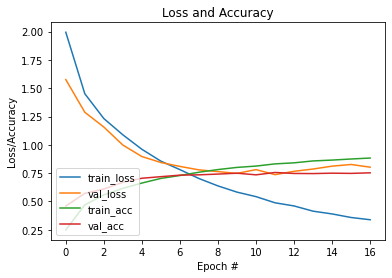

79/79 [==============================] - 0s 4ms/step - loss: 0.7363 - accuracy: 0.7555
Final test accuracy: 75.550%


In [16]:
# MaxPooling
max_pool_model = get_training_model()
max_pool_model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = max_pool_model.fit(trainloader,
                        epochs=40,
                        validation_data=testloader,
                        callbacks=[es])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(history)
acc = max_pool_model.evaluate(testloader)[1]
print("Final test accuracy: {:.3f}%".format(acc*100))

Epoch 1/40
391/391 [==============================] - 4s 10ms/step - loss: 2.0402 - accuracy: 0.2510 - val_loss: 1.4370 - val_accuracy: 0.5035
Epoch 2/40
391/391 [==============================] - 4s 9ms/step - loss: 1.4116 - accuracy: 0.4859 - val_loss: 1.2184 - val_accuracy: 0.5842
Epoch 3/40
391/391 [==============================] - 4s 9ms/step - loss: 1.1688 - accuracy: 0.5838 - val_loss: 1.0245 - val_accuracy: 0.6612
Epoch 4/40
391/391 [==============================] - 4s 9ms/step - loss: 1.0046 - accuracy: 0.6487 - val_loss: 0.9352 - val_accuracy: 0.6869
Epoch 5/40
391/391 [==============================] - 4s 9ms/step - loss: 0.8904 - accuracy: 0.6892 - val_loss: 0.8698 - val_accuracy: 0.7080
Epoch 6/40
391/391 [==============================] - 4s 9ms/step - loss: 0.7960 - accuracy: 0.7249 - val_loss: 0.8180 - val_accuracy: 0.7227
Epoch 7/40
391/391 [==============================] - 4s 9ms/step - loss: 0.7077 - accuracy: 0.7554 - val_loss: 0.8241 - val_accuracy: 0.7158
Epoch

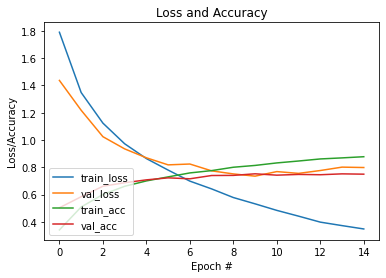

79/79 [==============================] - 0s 4ms/step - loss: 0.7352 - accuracy: 0.7524
Final test accuracy: 75.240%


In [17]:
# SoftPooling
soft_pool_model = get_training_model(pool_type=SoftPooling2D)
soft_pool_model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
start = time.time()
history = soft_pool_model.fit(trainloader,
                        epochs=40,
                        validation_data=testloader,
                        callbacks=[es])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(history)
acc = soft_pool_model.evaluate(testloader)[1]
print("Final test accuracy: {:.3f}%".format(acc*100))